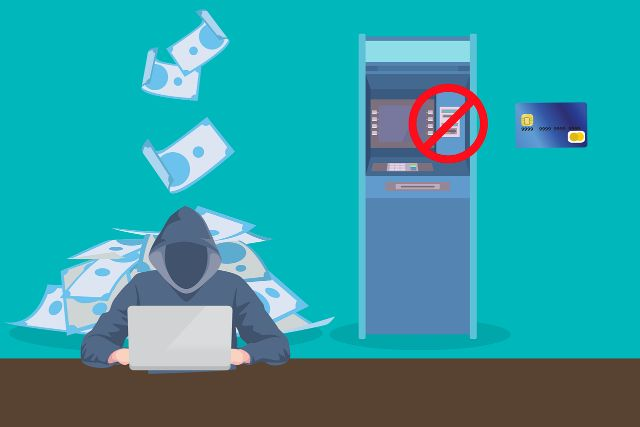

In [1]:
from IPython.display import Image
Image("fraud_dnn.jpg",width=400,height=350)

<b>Data Description</b>:

The dataset contains two-days credit card transactions made in September 2013 by European cardholders. 
The dataset is highly unbalanced with a low percentage of fraudulent transactions within several records of normal transactions. 

The negative class(No Frauds) accounts for 99.83% of the dataset.
The positive class (frauds) account for 0.172% (492 frauds out of 284,807 transactions) of all transactions.

Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
Feature 'Class' is the target variable with value 1 in case of fraud and 0 otherwise.

<b>Points about dataset</b>:
- All columns are continuous variables.
- It is highly imbalanced dataset. 
 - Never test on the oversampled or undersampled dataset.
 - If we want to implement cross validation, remember to oversample or undersample your training data during cross-validation, not before!
 - Do not use accuracy score as a metric with imbalanced datasets (will be usually high and misleading), instead use f1-score, precision/recall score or confusion matrix
- Columns are extracted PCA(because of privacy issues) so assumption is they are alrady scaled before pca transofrmation.
- It is large dataset with more than 200000 rows. 
- It does not have any missing values.

In [2]:
#import libraries
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # Plot the graphes
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
import seaborn as sns
from sklearn.preprocessing import StandardScaler as ss
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
sns.set()
import sklearn.metrics as metrics
import xgboost as xgb
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import ADASYN 
from sklearn.ensemble import AdaBoostClassifier

In [3]:
fraud_data=pd.read_csv("creditcard.csv")
print('The dataset contains {0} rows and {1} columns. '.format(fraud_data.shape[0],fraud_data.shape[1]))

The dataset contains 284807 rows and 31 columns. 


EDA:Exploratory Data Analysis

In [8]:
#view top five rows
fraud_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
fraud_data.isnull().values.any()

False

Note: Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Text(0, 0.5, 'frequency')

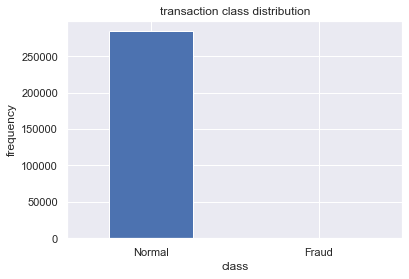

In [5]:
LABELS = ["Normal", "Fraud"]
count_classes=pd.value_counts(fraud_data['Class'],sort=True)
count_classes.plot(kind='bar',rot=0)
plt.title("transaction class distribution")
plt.xticks(range(2),LABELS)
plt.xlabel("class")
plt.ylabel("frequency")

In [10]:
fraud_data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

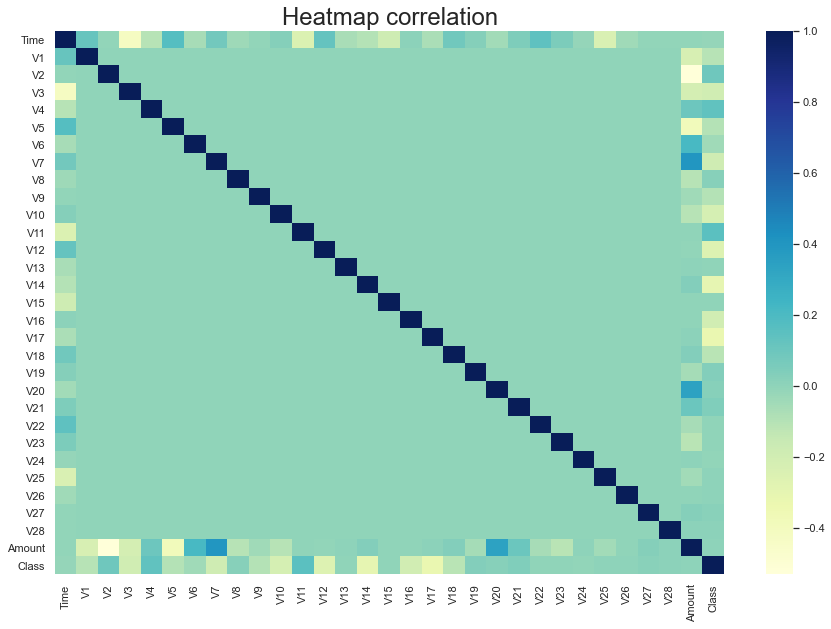

In [11]:
fraud_data_corr=fraud_data.corr()
plt.figure(figsize=(15,10))
sn.heatmap(fraud_data_corr, cmap="YlGnBu") # Displaying the Heatmap
sn.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

In [4]:
frauds=fraud_data[fraud_data.Class==1]
normal=fraud_data[fraud_data.Class==0]

In [7]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [8]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

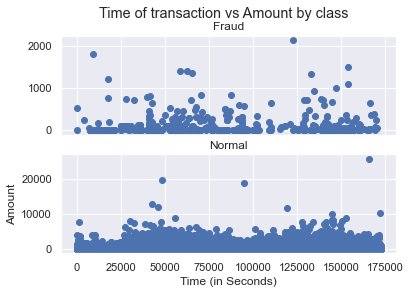

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [ ]:
Does fraud transaction occurs more at certain time? not really

<b>Distributions</b>: 
By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features.

/Users/aydafarhadi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aydafarhadi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


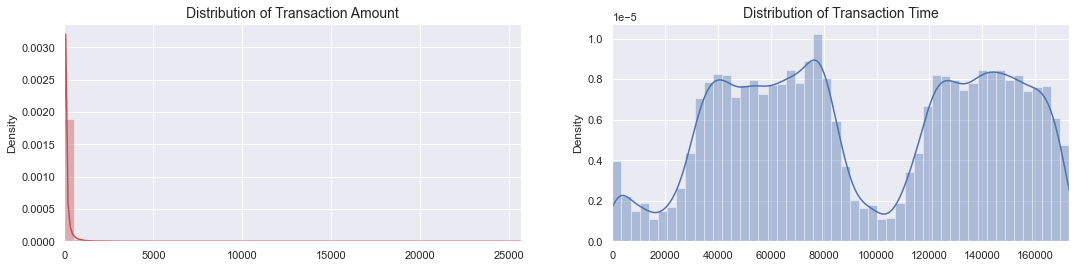

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = fraud_data['Amount'].values
time_val = fraud_data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [5]:
scaler = StandardScaler()
fraud_data['normalize_amount']=scaler.fit_transform(fraud_data['Amount'].values.reshape(-1,1))

In [6]:
data=fraud_data.drop(['Amount','Time'],axis=1)

In [7]:
#features and label class
X_data=data.drop(['Class'],axis=1)
y_label=data['Class']

In [8]:
#split data into training set(%80) and test set(%20)
X_train,X_test,y_train,y_test=train_test_split(X_data,y_label,stratify=y_label,test_size=.3,random_state=70)
print("training data is",X_train.shape)
print("test data is", y_test.shape)

training data is (199364, 29)
test data is (85443,)


In [20]:
pca_vars=['V%i' % k for k in range (1,29)]

In [21]:
X_train[pca_vars].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000
mean,-0.000373,-0.003156,0.000555,0.000863,-0.002057,-0.001604,-0.000889,-0.000197,0.001305,0.002031,...,0.001883,-0.000224,0.000400,0.000152,-0.000454,0.000082,-0.001080,-0.000142,-0.000017,0.000477
std,1.959944,1.656220,1.509295,1.415736,1.359088,1.322001,1.208827,1.193544,1.099059,1.089984,...,0.813238,0.775649,0.732821,0.726693,0.636407,0.605423,0.521761,0.482577,0.402823,0.330609
min,-46.855047,-63.344698,-31.813586,-5.683171,-42.147898,-23.496714,-43.557242,-73.216718,-13.434066,-24.588262,...,-7.213527,-28.009635,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896
25%,-0.920944,-0.601083,-0.892095,-0.849040,-0.695503,-0.768956,-0.554220,-0.209158,-0.640874,-0.534306,...,-0.455223,-0.211656,-0.228270,-0.542754,-0.161589,-0.355061,-0.317461,-0.327128,-0.070933,-0.052784
50%,0.018598,0.063897,0.182127,-0.018300,-0.055939,-0.274141,0.039758,0.022354,-0.051003,-0.092253,...,0.005666,-0.062040,-0.029438,0.006826,-0.010804,0.040920,0.015823,-0.052182,0.001301,0.011375
75%,1.315808,0.803658,1.028133,0.743947,0.611240,0.397196,0.569780,0.327544,0.599408,0.454894,...,0.460247,0.133549,0.186850,0.529250,0.148072,0.439027,0.349452,0.240441,0.091755,0.078682
max,2.454930,22.057729,9.382558,16.875344,34.099309,23.917837,44.054461,19.168327,15.594995,23.745136,...,5.591971,39.420904,27.202839,10.503090,22.528412,4.022866,7.519589,3.463246,12.152401,22.620072


<b>Outliers</b>:

Text(0.5, 1.0, 'V1-V28 Means')

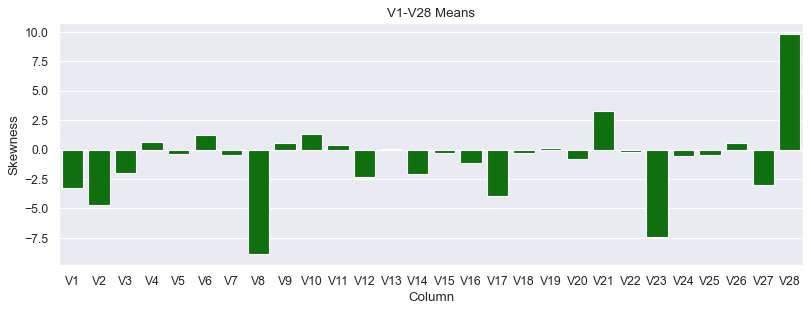

In [22]:
plt.figure(figsize=(12,4),dpi=80)
sns.barplot(x=pca_vars, y=X_train[pca_vars].skew(),color='green')
plt.xlabel('Column')
plt.ylabel('Skewness')
plt.title('V1-V28 Means')

A few of the PCA variables are significantly skewed. 
Lets plot a histogram of one of the particularly skewed variables, V8, to see the distribution in detail.

/Users/aydafarhadi/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'V8')

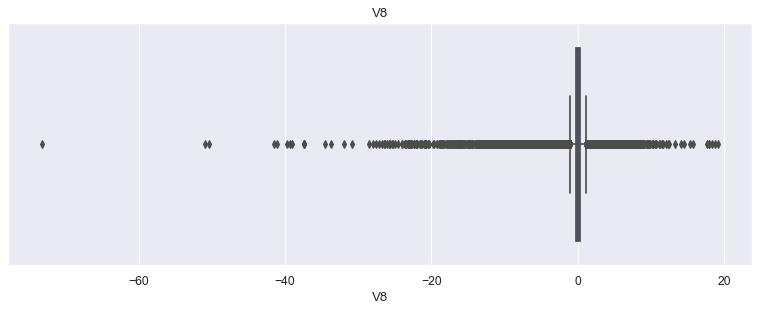

In [14]:
plt.figure(figsize=(12,4), dpi=80)
sns.boxplot(X_train['V8'])
plt.title('V8')

The boxplot is also hard to read due to the large number of outliers, which indicates high kurtosis in V8.